In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import yfinance as yf
import datetime as dt
import warnings

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 5)

Using TensorFlow backend.


In [2]:
df = yf.download('BTC-USD', start='2016-01-01', end='2020-07-07', interval='1d', prepost=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.tail(3) #bitcoin

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-04,9084.233398,9183.295898,9053.629883,9132.488281,9132.488281,12290528515
2020-07-05,9126.090820,9162.183594,8977.015625,9073.942383,9073.942383,12903406143
2020-07-06,9072.849609,9375.474609,9058.664062,9375.474609,9375.474609,17889263252


In [4]:
def finance_pred(df):
    df['Average'] = (df['High'] + df['Low'])/2
    df_new = pd.DataFrame(index=range(0,len(df)), columns=['Date', 'Volume', 'Average'])
    
    for i in range(0,len(df)):
        df_new['Date'][i] = df.index[i]
        df_new['Volume'][i] = df['Volume'][i]
        df_new['Average'][i] = df['Average'][i]
        
    df_new.index = df_new.Date
    df_new.drop('Date', axis=1, inplace=True)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df_new.values)
    
    train = df_scaled[:int(df.shape[0]*0.8)]
    test = df_scaled[int(df.shape[0]*0.8):]
    
    x_train,y_train,x_test,y_test = [],[],[],[]
    for i in range(50,train.shape[0]):
        x_train.append(train[i-50:i,0:])
        y_train.append(train[i,1])
    for z in range(50,test.shape[0]):
        x_test.append(test[z-50:z,0:])
        y_test.append(test[z,1])
        
    x_train,y_train,x_test,y_test = np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],2)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],2)
    
    return (x_train, y_train, x_test, y_test)

def loss_pred(history,y_train,p_train):
    plt.figure(figsize=(17, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(y_train, label='true')
    plt.plot(p_train, label='pred')
    plt.legend();
    return

In [5]:
x_train, y_train, x_test, y_test = finance_pred(df)

In [11]:
model = Sequential()
model.add(LSTM(units=30,input_shape=(x_train.shape[1],2),return_sequences=True))
model.add(LSTM(units=30,return_sequences=True))
model.add(LSTM(units=30))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=50, verbose=0, batch_size=64, shuffle=False)
p_train = model.predict(x_train)

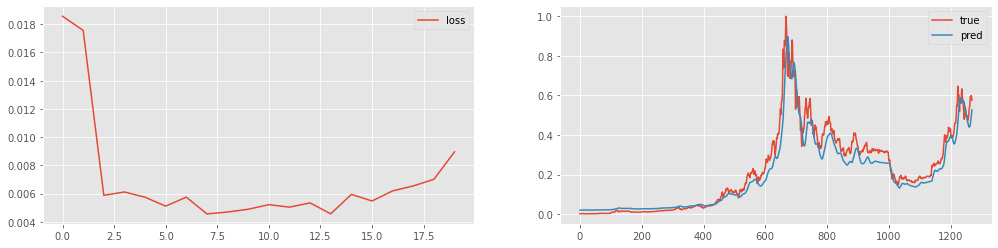

In [8]:
# epochs=20, batch_size=32
loss_pred(history,y_train,p_train)

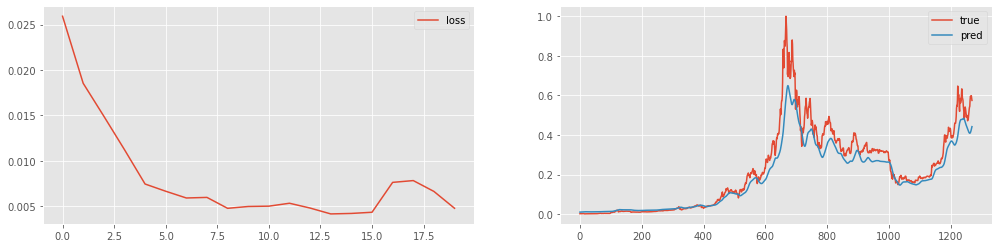

In [10]:
# epochs=20, batch_size=64
loss_pred(history,y_train,p_train)

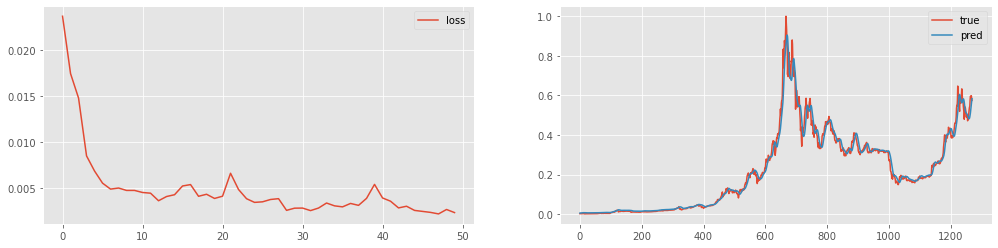

In [12]:
# epochs=50, batch_size=64
loss_pred(history,y_train,p_train)